A third one?! 

# Coarsen Data Part III!!

adi stein, 3.15.2023

Here I want to try with PDSI instead

In [1]:
import xarray as xr
import numpy as np
import dask
import dask.array as da

import sys
sys.path.append('../../')

import ndrought.wrangle as ndw

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

#from ndrought.plotting import usdm_cmap

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load in Data

In [2]:
pdsi_da = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/pdsi/CONUS_105W/pdsi.nc')['pdsi'].load()

In [3]:
pdsi_da

<xarray.DataArray 'pdsi' (time: 3066, y: 702, x: 525)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 -2.893e+06 -2.889e+06 ... -6.674e+05 -6.632e+05
  * y        (y) float64 3.251e+06 3.246e+06 3.242e+06 ... 2.717e+05 2.674e+05
  * time     (time) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
Attributes:
    units:              
    description:        Palmer Drought Severity Index
    long_name:          pdsi
    standard_name:      pdsi
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    coordinates:        lon lat
    grid_mapping:       crs

In [4]:
25000/(pdsi_da.x.values[1] - pdsi_da.x.values[0])

5.874340415052207

Found that using `coarsen` to apply a method leaded to some strange results in outputting that couldn't figure out and seemed out of my control ... but it is helpful for windowing our data.

In [5]:
pdsi_da_windowed = pdsi_da.coarsen({'x':5, 'y':5}, boundary='trim').construct(
    x=("x_coarse", "x_window"),
    y=("y_coarse", "y_window")
)

In [6]:
pdsi_da_windowed

<xarray.DataArray 'pdsi' (time: 3066, y_coarse: 140, y_window: 5, x_coarse: 105, x_window: 5)>
array([[[[[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan]]]]], dtype=float32)
Coordinates:
    x        (x_coarse, x_window) float64 -2.893e+06 -2.889e+06 ... -6.632e+05
    y        (y_coarse, y_window) float64 3.251e+06 3.246e+06 ... 2.759e+05
  * time     (time) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
Dimensions without coordinates: y_coarse, y_window, x_coarse, x_window
Attributes:
    units:              
    description:        Palmer Drought Severity Index
    long_name:          pdsi
    standard_name:      pdsi
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    coordinates:        lon lat
    grid_mapping:       crs

Let's then start with defining mode before getting to DCVW, since it's part of the method

In [7]:
def mode(a):
    uniq = np.unique(a, return_counts=True)
    return uniq[0][np.argmax(uniq[1])]

Now to loop through our data and compute the mode. We'll reshape after.

In [8]:
pdsi_da.sel(time='2015-01').time

<xarray.DataArray 'time' (time: 6)>
array(['2015-01-05T00:00:00.000000000', '2015-01-10T00:00:00.000000000',
       '2015-01-15T00:00:00.000000000', '2015-01-20T00:00:00.000000000',
       '2015-01-25T00:00:00.000000000', '2015-01-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-05 2015-01-10 ... 2015-01-30
Attributes:
    description:    days since 1900-01-01
    long_name:      time
    standard_name:  time

In [9]:
ny = pdsi_da_windowed['y_coarse']
nx = pdsi_da_windowed['x_coarse']
times = pdsi_da_windowed['time']

prog = tqdm(total=(len(ny)*len(nx)))

all_subs = []
#for t in times: # only going to run it for one time for now to speed up (otherwise 2 hrs)
for yy in ny:
    for xx in nx:
        all_subs.append(
            mode(pdsi_da_windowed.sel(time='2015-01-05', y_coarse=yy, x_coarse=xx).values)
        )
        prog.update()

  0%|          | 0/14700 [00:00<?, ?it/s]

In [10]:
# bit of hard coding for our example
reshaped = np.reshape(np.array(all_subs), (1, 140, 105))

Let's now take a look at a plot

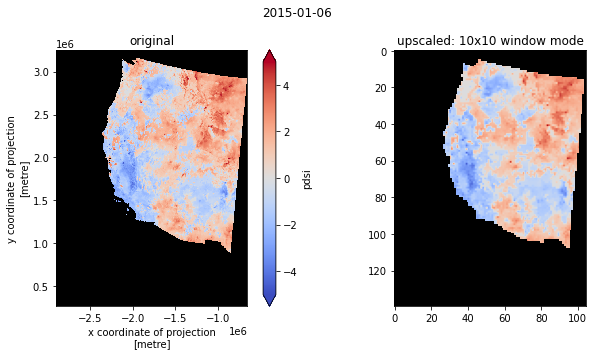

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

pdsi_da.sel(time='2015-01-05').plot(ax=axs[0], vmin=-5, vmax=5, cmap='coolwarm')
axs[0].set_title('original')

axs[1].imshow(reshaped[0, :, :], cmap='coolwarm', vmin=-5, vmax=5)
axs[1].set_title('upscaled: 10x10 window mode')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_facecolor('k')

fig.suptitle('2015-01-06')
fig.set_facecolor('w')
plt.tight_layout()

That looks pretty good!

Now onto DCVW: https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1847603

First need to construct our trend surface. The article mentions settling on a quadratic, so that's what we'll do here

In [28]:
polyfit_coeff = pdsi_da_windowed.polyfit(dim="time", deg=2)['polyfit_coefficients']

Now to define our function according to equations 18-20 in the paper.

In [72]:
def dcvw(win, poly):
    
    ts = 0

    for d in np.arange(len(poly.degree)):
        ts += poly.isel(degree=d).values * (win**d)

    m = mode(ts)

    w_numer = ((ts-m)**2)
    w_denom = (((ts-m)**2).sum())
    w = w_numer/w_denom

    #print(ts)
    #print(m)
    #print(ts-m)
    #print((ts-m)**2)
    #print(w_denom)
    print(w)
    print()

    return (w*ts).sum()

Then apply like before!

In [73]:
ny = pdsi_da_windowed['y_coarse']
nx = pdsi_da_windowed['x_coarse']
times = pdsi_da_windowed['time']

prog = tqdm(total=(len(ny)*len(nx)))

all_subs = []
#for t in times:
for yy in ny:
    for xx in nx:
        all_subs.append(
            dcvw(
                pdsi_da_windowed.sel(time='2015-01-05', y_coarse=yy, x_coarse=xx).values,
                polyfit_coeff.sel(y_coarse=yy, x_coarse=xx)
            )
        )
        prog.update()

  0%|          | 0/14700 [00:00<?, ?it/s]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan 

In [74]:
reshaped = np.reshape(np.array(all_subs), (1, 140, 105))

Now for the moment of truth ...

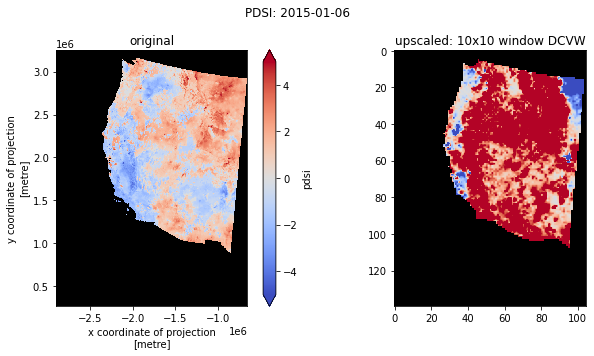

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

pdsi_da.sel(time='2015-01-05').plot(cmap='coolwarm', vmin=-5, vmax=5, ax=axs[0])
axs[0].set_title('original')

axs[1].imshow(reshaped[0, :, :], cmap='coolwarm', vmin=-5, vmax=5)
axs[1].set_title('upscaled: 10x10 window DCVW')

for ax in axs:
    ax.set_aspect('equal')
    ax.set_facecolor('k')

fig.suptitle('PDSI: 2015-01-06')
fig.set_facecolor('w')
plt.tight_layout()

Huh. That's not at all what I was expecting ...